# Toy Stretch Reflex (Spindle + Alpha Motoneuron)

## Overview

Goal: implement a simple, biologically grounded stretch reflex block that we can later embed in MuJoCo.

This notebook implements a **toy stretch reflex** consisting of:
1. **Muscle spindle (Ia) afferent** — simplified rate model driven by muscle length and velocity.  
2. **Golgi tendon organ (Ib) afferent** — simplified rate model driven by tendon/muscle force (optional in first pass).  
3. **Alpha motoneuron (α-MN)** — rate-coded unit integrating afferent inputs to produce muscle activation.  
4. **Hill-type muscle (lumped)** — converts activation to force, with simple force–length–velocity effects.

We simulate a **step stretch** in muscle length and show how the reflex increases activation and force to oppose it.
Later, we can couple this block to a **single-DOF joint** in MuJoCo.

## References (for orientation only)

- Matthews, P. B. C. (1991). The human stretch reflex and the motor cortex. *Trends in Neurosciences*, 14(3), 87–91.  
- Mileusnic, M. P., Brown, I. E., Lan, N., & Loeb, G. E. (2006). Mathematical models of proprioceptors. I. Control and transduction in the muscle spindle. *Journal of Neurophysiology*, 96(4), 1772–1788.  
- Prochazka, A. & Gorassini, M. (1998). Models of ensemble firing of muscle spindle afferents during locomotion. *J Physiol*.  
- Zajac, F. E. (1989). Muscle and tendon: properties, models, scaling, and application. *CRC Crit Rev Biomed Eng*, 17(4), 359–411.

## Model Sketch (simplified)

**Spindle primary (Ia) rate**
- $Ia = Ia_0 + k_L * (L - L_0) + k_V * max(0, dL/dt)$  
  Captures static length sensitivity and dynamic (velocity) sensitivity.

**Golgi tendon organ (Ib) rate (optional first pass)**
- $Ib = Ib_0 + k_F * F_m$

**Alpha motoneuron (rate unit)**
- $\tau_{mn} * da_{mn}/dt = -a_{mn} + ReLU(w_{Ia} * Ia - w_{Ib} * Ib + bias)$ 
- Output activation $u = sigmoid(a_{mn})$ in [0, 1].

**Muscle (lumped Hill-type)**
- Activation dynamics: $\tau_{act} * dA/dt = -A + u$ 
- Force: $Fm = F_{max} * A * f_L(L) * f_V(dL/dt)$
  - $f_L(L) = exp(-((L - L_{opt})/w_L)^2)$
  - $fV(dL/dt) = 1 / (1 + c_V * dL/dt)$ (clipped to stay positive)

For a toy **stretch** test, we impose a length trajectory $L(t)$ with a smooth step at $t = t_{step}$.

## Parameters

- Spindle: $Ia_0$, $k_L$, $k_V$  
- Golgi: $Ib_0$, $k_F$  
- α-MN: $\tau_{mn}$, $w_{Ia}$, $w_{Ib}$, bias  
- Activation: $\tau_{act}$  
- Muscle: $F_{max}$, $L_{opt}$, $w_L$, $c_V$  
- Length trajectory: baseline $L_0$, step amplitude $dL$, step time $t_{step}$

## I. Implementation

In [60]:
import os
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from dataclasses import dataclass

In [61]:
@dataclass
class SpindleParams:
    Ia0: float = 50.0
    kL: float  = 800.0
    kV: float  = 60.0

@dataclass
class GolgiParams:
    Ib0: float = 10.0
    kF: float  = 0.00

@dataclass
class MNParams:
    tau_mn: float = 0.02
    w_Ia:  float = 0.004
    w_Ib:  float = 0.000
    bias:  float = 0.0

@dataclass
class MuscleParams:
    tau_act: float = 0.03
    Fmax:   float = 1500.0
    Lopt:   float = 1.0
    wL:     float = 0.25
    cV:     float = 2.0

@dataclass
class StretchProfile:
    L0: float = 1.0
    dL: float = 0.02
    t_step: float = 0.5
    t_end: float = 2.0

In [62]:
def length_trajectory(t: float, prof: StretchProfile):
    """Compute the muscle length and velocity over time using a smooth step function."""
    # Smooth step in length at t_step using tanh for numerical stability.
    k = 60.0  # steepness of transition
    s = 0.5 * (1 + np.tanh(k * (t - prof.t_step)))
    L = prof.L0 + prof.dL * s
    dLdt = prof.dL * 0.5 * k * (1 - np.tanh(k * (t - prof.t_step))**2)
    return L, dLdt

In [63]:
def spindle_Ia(L, dLdt, p: SpindleParams):
    """Compute the firing rate of the muscle spindle's Ia afferent."""
    v_pos = max(0.0, dLdt)
    return p.Ia0 + p.kL*(L - 1.0) + p.kV*v_pos

def golgi_Ib(Fm, p: GolgiParams):
    """Compute the firing rate of the Golgi tendon organ's Ib afferent."""
    return p.Ib0 + p.kF * max(0.0, Fm)

def relu(x): 
    """Compute the ReLU (Rectified Linear Unit) activation function."""
    return x if x > 0 else 0.0

def sigmoid(x):
    """Compute the sigmoid activation function."""
    return 1.0 / (1.0 + np.exp(-x))

def fL(L, mp: MuscleParams):
    """Compute the force-length relationship of the muscle."""
    return np.exp(-((L - mp.Lopt) / mp.wL)**2)

def fV(dLdt, mp):
    """Compute the force-velocity relationship of the muscle."""
    # Clamp dLdt to a reasonable range
    dLdt_clamped = np.clip(dLdt, -100.0, 100.0)
    val = 1.0 / (1.0 + mp.cV * dLdt_clamped)
    return max(0.05, min(val, 1.0))

def muscle_force(A, L, dLdt, mp: MuscleParams):
    """Compute the total muscle force based on activation, length, and velocity."""
    return mp.Fmax * A * fL(L, mp) * fV(dLdt, mp)

In [64]:
def reflex_ode(t, y, sp: SpindleParams, gb: GolgiParams, mn: MNParams, mp: MuscleParams, prof: StretchProfile):
    """
    System of ordinary differential equations (ODEs) for the reflex arc.

    This function models the dynamics of the alpha motoneuron and muscle activation 
    in response to proprioceptive feedback from the muscle spindle (Ia) and Golgi tendon organ (Ib).
    """
    # system of ODEs for the reflex arc
    a_mn, A = y
    L, dLdt = length_trajectory(t, prof)
    
    Ia = spindle_Ia(L, dLdt, sp)
    Fm = muscle_force(A, L, dLdt, mp)
    Ib = golgi_Ib(Fm, gb)
    
    I = mn.w_Ia * Ia - mn.w_Ib * Ib + mn.bias
    da_mn = (-a_mn + max(0.0, I)) / mn.tau_mn
    
    u = sigmoid(a_mn)
    dA = (-A + u) / mp.tau_act
    
    return [da_mn, dA]

In [65]:
# Initialize parameters
sp = SpindleParams()
gb = GolgiParams(kF=0.01)
mn = MNParams(w_Ia=0.004, w_Ib=0.002, bias=0.0)
mp = MuscleParams()
prof = StretchProfile(dL=0.02, t_step=0.5, t_end=2.0)

# Set initial conditions and time span
y0 = [0.0, 0.05]
t_span = (0.0, prof.t_end)
t_eval = np.linspace(t_span[0], t_span[1], 1501)

# Solve the ODE for the reflex arc
sol = solve_ivp(lambda t, y: reflex_ode(t, y, sp, gb, mn, mp, prof),
                t_span, y0, t_eval=t_eval, rtol=1e-6, atol=1e-8)

# Extract simulation results
t = sol.t
a_mn = sol.y[0]
A = sol.y[1]

# Compute additional variables for analysis
L = np.zeros_like(t); dLdt = np.zeros_like(t); Ia = np.zeros_like(t); Fm = np.zeros_like(t)
for i, ti in enumerate(t):
    Li, dLi = length_trajectory(ti, prof)
    L[i] = Li; dLdt[i] = dLi
    Ia[i] = spindle_Ia(Li, dLi, sp)
    Fm[i] = muscle_force(A[i], Li, dLi, mp)

print("Simulation complete.")

Simulation complete.


In [66]:
SAVE_DIR = "../results/"
ORIGINAL_DIR = SAVE_DIR + "original/"
os.makedirs(ORIGINAL_DIR, exist_ok=True)

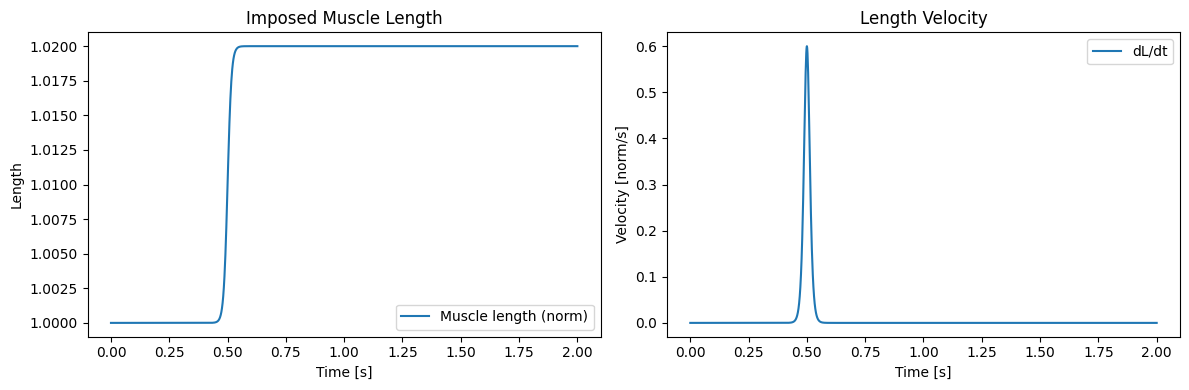

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot muscle length
axs[0].plot(t, L, label="Muscle length (norm)")
axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel("Length")
axs[0].set_title("Imposed Muscle Length")
axs[0].legend()

# Plot muscle velocity
axs[1].plot(t, dLdt, label="dL/dt")
axs[1].set_xlabel("Time [s]")
axs[1].set_ylabel("Velocity [norm/s]")
axs[1].set_title("Length Velocity")
axs[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(ORIGINAL_DIR, "muscle_length_velocity.png"))
plt.show()
plt.close()

- **Muscle Length Plot:** The muscle length smoothly increases from 1.0 to 1.02 at $t = 0.5$ following the expected tanh curve.
- **Length Velocity Plot:** The length velocity exhibits a sharp positive twitch at $t = 0.5$, consistent with the derivative of the tanh transition.

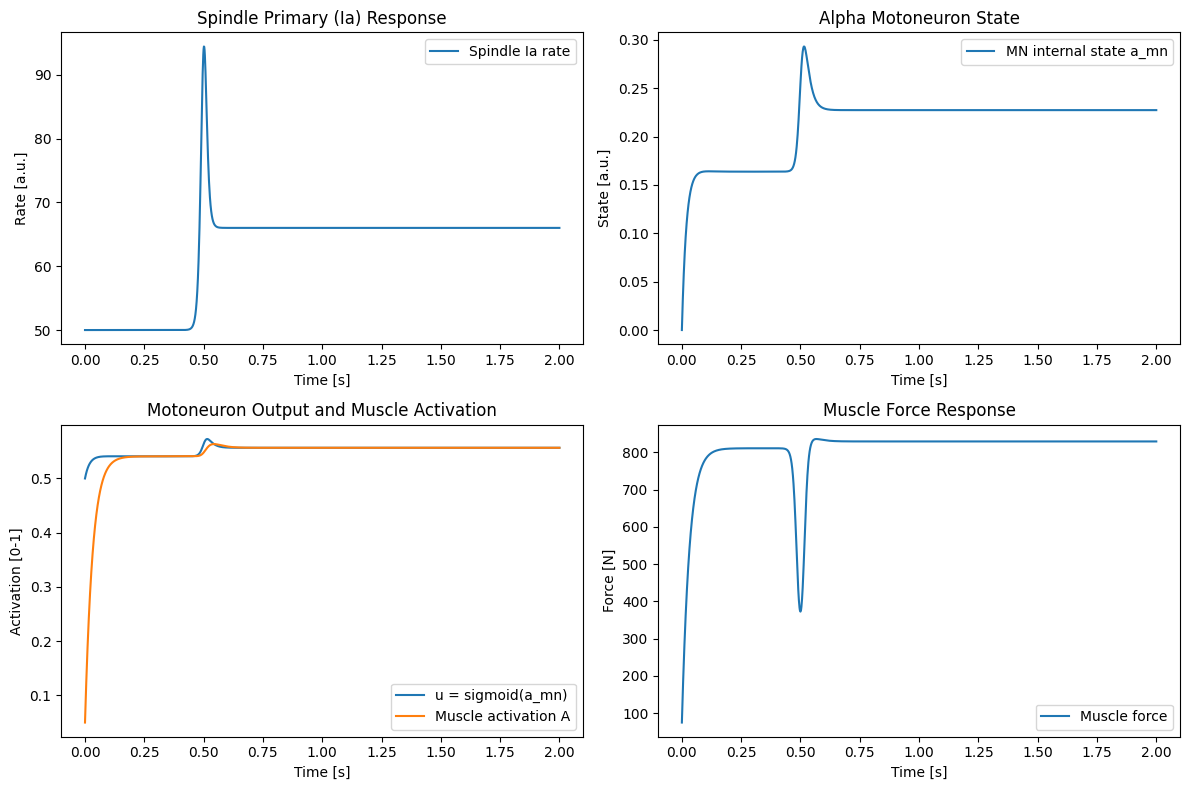

In [68]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot spindle Ia rate
axs[0, 0].plot(t, Ia, label="Spindle Ia rate")
axs[0, 0].set_xlabel("Time [s]")
axs[0, 0].set_ylabel("Rate [a.u.]")
axs[0, 0].set_title("Spindle Primary (Ia) Response")
axs[0, 0].legend()

# Plot alpha motoneuron state
axs[0, 1].plot(t, a_mn, label="MN internal state a_mn")
axs[0, 1].set_xlabel("Time [s]")
axs[0, 1].set_ylabel("State [a.u.]")
axs[0, 1].set_title("Alpha Motoneuron State")
axs[0, 1].legend()

# Plot motoneuron output and muscle activation
axs[1, 0].plot(t, 1 / (1 + np.exp(-a_mn)), label="u = sigmoid(a_mn)")
axs[1, 0].plot(t, A, label="Muscle activation A")
axs[1, 0].set_xlabel("Time [s]")
axs[1, 0].set_ylabel("Activation [0-1]")
axs[1, 0].set_title("Motoneuron Output and Muscle Activation")
axs[1, 0].legend()

# Plot muscle force response
axs[1, 1].plot(t, Fm, label="Muscle force")
axs[1, 1].set_xlabel("Time [s]")
axs[1, 1].set_ylabel("Force [N]")
axs[1, 1].set_title("Muscle Force Response")
axs[1, 1].legend()

plt.tight_layout()
plt.savefig(os.path.join(ORIGINAL_DIR, "muscle_response.png"))
plt.show()
plt.close()

- **Spindle Primary Response:** The $I_a$ firing rate increases sharply at $t = 0.5$, reflecting the muscle's sensitivity to the imposed stretch.
- **Alpha Motoneuron State:** The motoneuron internal state $a_{mn}$ rises quickly after $t = 0.5$, showing activation in response to the $I_a$ input.
- **Motoneuron Output and Muscle Activation:** The motoneuron output $u$ (sigmoid of $a_{mn}$) and muscle activation $A$ both increase after $t = 0.5$, with $A$ lagging slightly due to activation dynamics.
- **Muscle Force Response:** Muscle force $F_m$ decreases sharply at $t = 0.5$ due to the force–velocity relationship during rapid lengthening, then rises again as muscle activation increases.

## II. Add inhibition

In [69]:
# Parameters for with inhibition
gb_inh = GolgiParams(kF=0.1)
mn_inh = MNParams(w_Ia=0.004, w_Ib=0.01, bias=0.0)

# Solve the ODE for the reflex arc
sol_inh = solve_ivp(lambda t, y: reflex_ode(t, y, sp, gb_inh, mn_inh, mp, prof),
                                 t_span, y0, t_eval=t_eval, rtol=1e-6, atol=1e-8)

# Extract simulation results
t = sol_inh.t
a_mn_inh = sol_inh.y[0]
A_inh = sol_inh.y[1]

# Compute additional variables for analysis
L = np.zeros_like(t); dLdt = np.zeros_like(t)
Ia_inh = np.zeros_like(t); Fm_inh = np.zeros_like(t)

for i, ti in enumerate(t):
    Li, dLi = length_trajectory(ti, prof)
    L[i] = Li; dLdt[i] = dLi
    Ia_inh[i] = spindle_Ia(Li, dLi, sp)
    Fm_inh[i] = muscle_force(A_inh[i], Li, dLi, mp)

print("Simulation complete.")

Simulation complete.


In [70]:
INHIBITION_DIR = SAVE_DIR + "inhibition/"
os.makedirs(INHIBITION_DIR, exist_ok=True)

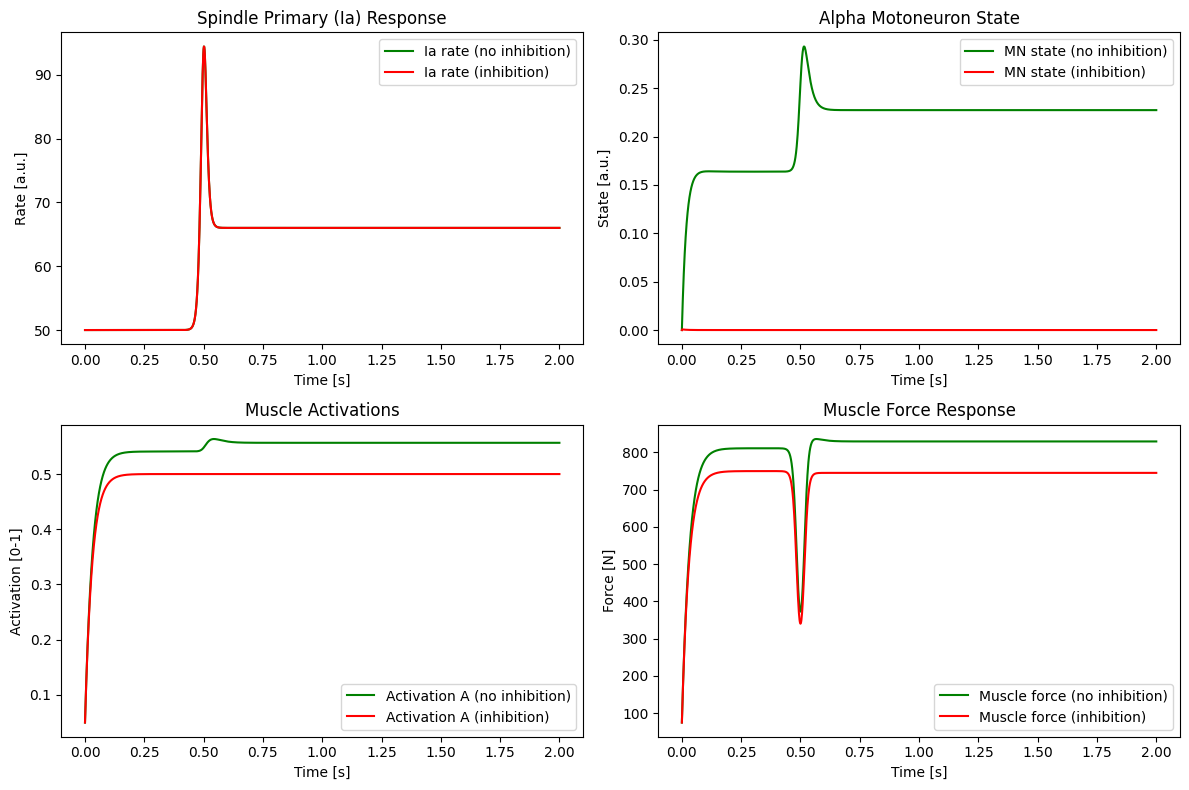

In [71]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot spindle Ia rate
axs[0, 0].plot(t, Ia, color="green", label="Ia rate (no inhibition)")
axs[0, 0].plot(t, Ia_inh, color="red", label="Ia rate (inhibition)")
axs[0, 0].set_xlabel("Time [s]")
axs[0, 0].set_ylabel("Rate [a.u.]")
axs[0, 0].set_title("Spindle Primary (Ia) Response")
axs[0, 0].legend()

# Plot alpha motoneuron state
axs[0, 1].plot(t, a_mn, color="green", label="MN state (no inhibition)")
axs[0, 1].plot(t, a_mn_inh, color="red", label="MN state (inhibition)")
axs[0, 1].set_xlabel("Time [s]")
axs[0, 1].set_ylabel("State [a.u.]")
axs[0, 1].set_title("Alpha Motoneuron State")
axs[0, 1].legend()

# Plot muscle activations
axs[1, 0].plot(t, A, color="green", label="Activation A (no inhibition)")
axs[1, 0].plot(t, A_inh, color="red", label="Activation A (inhibition)")
axs[1, 0].set_xlabel("Time [s]")
axs[1, 0].set_ylabel("Activation [0-1]")
axs[1, 0].set_title("Muscle Activations")
axs[1, 0].legend()

# Plot muscle force response
axs[1, 1].plot(t, Fm, color="green", label="Muscle force (no inhibition)")
axs[1, 1].plot(t, Fm_inh, color="red", label="Muscle force (inhibition)")
axs[1, 1].set_xlabel("Time [s]")
axs[1, 1].set_ylabel("Force [N]")
axs[1, 1].set_title("Muscle Force Response")
axs[1, 1].legend()

plt.tight_layout()
plt.savefig(os.path.join(INHIBITION_DIR, "inhibition_comparison.png"))
plt.show()
plt.close()

- **Spindle Primary Response:** The $I_a$ rate remains the same with and without inhibition because it depends only on muscle length and velocity, which are unaffected by $I_b$ inhibition.
- **Alpha Motoneuron State:** The $a_{mn}$ state is 0 with inhibition because the inhibitory $I_b$ input outweighs the excitatory $I_a$ input, driving the motoneuron state to zero.
- **Motoneuron Output and Muscle Activation:** The motoneuron output $u$ and muscle activation $A$ are lower with inhibition because the reduced $a_{mn}$ directly decreases activation.
- **Muscle Force Response:** Muscle force $F_m$ is slightly lower with inhibition due to the reduced muscle activation $A$, which directly scales the force.

## III. Antagonist pair with reciprocal inhibition

In [72]:
def reflex_ode_ant(t, y, sp, gb, mn, mp, sp_ant, gb_ant, mn_ant, mp_ant, prof):
    """
    ODE system for coupled agonist-antagonist muscles with reciprocal inhibition.

    This function models the dynamics of two muscles (agonist and antagonist) acting on a joint,
    including reciprocal inhibition between the muscles.
    """
    a_mn, A, a_mn_ant, A_ant = y
    L, dLdt = length_trajectory(t, prof)
    
    # Dynamics
    Ia = spindle_Ia(L, dLdt, sp)
    Fm = muscle_force(A, L, dLdt, mp)
    Ib = golgi_Ib(Fm, gb)
    
    Ia_ant = spindle_Ia(L, dLdt, sp_ant)
    Fm_ant = muscle_force(A_ant, L, dLdt, mp_ant)
    Ib_ant = golgi_Ib(Fm_ant, gb_ant)
    
    # Reciprocal inhibition
    I_agonist = mn.w_Ia * Ia - mn.w_Ib * Ib - 0.002 * Ia_ant  # Reciprocal inhibition from antagonist
    I_antagonist = mn_ant.w_Ia * Ia_ant - mn_ant.w_Ib * Ib_ant - 0.002 * Ia  # Reciprocal inhibition from agonist
    
    # Motoneuron and activation dynamics
    da_mn = (-a_mn + max(0.0, I_agonist)) / mn.tau_mn
    u = sigmoid(a_mn)
    dA = (-A + u) / mp.tau_act
    
    da_mn_ant = (-a_mn_ant + max(0.0, I_antagonist)) / mn_ant.tau_mn
    u_ant = sigmoid(a_mn_ant)
    dA_ant = (-A_ant + u_ant) / mp_ant.tau_act
    
    return [da_mn, dA, da_mn_ant, dA_ant]

In [73]:
# Parameters for antagonist muscle
sp_ant = SpindleParams() 
gb_ant = GolgiParams(kF=0.02)  
mn_ant = MNParams(w_Ia=0.006, w_Ib=0.005, bias=0.0)  
mp_ant = MuscleParams() 

# Extend the state vector
y0 = [0.0, 0.05, 0.0, 0.06]  # [a_mn, A, a_mn_ant, A_ant]

# Solve the ODE for the coupled muscles
sol = solve_ivp(lambda t, y: reflex_ode_ant(t, y, sp, gb, mn, mp, sp_ant, gb_ant, mn_ant, mp_ant, prof),
                t_span, y0, t_eval=t_eval, rtol=1e-6, atol=1e-8)

# Extract simulation results
t = sol.t
a_mn = sol.y[0]
A = sol.y[1]
a_mn_ant = sol.y[2]
A_ant = sol.y[3]

# Compute additional variables for analysis
L = np.zeros_like(t); dLdt = np.zeros_like(t)
Ia = np.zeros_like(t); Fm = np.zeros_like(t)
Ia_ant = np.zeros_like(t); Fm_ant = np.zeros_like(t)

for i, ti in enumerate(t):
    Li, dLi = length_trajectory(ti, prof)
    L[i] = Li; dLdt[i] = dLi
    Ia[i] = spindle_Ia(Li, dLi, sp)
    Fm[i] = muscle_force(A[i], Li, dLi, mp)
    Ia_ant[i] = spindle_Ia(Li, dLi, sp)
    Fm_ant[i] = muscle_force(A_ant[i], Li, dLi, mp)

print("Simulation complete.")

Simulation complete.


In [74]:
ANTAGONIST_DIR = SAVE_DIR + "antagonist/"
os.makedirs(ANTAGONIST_DIR, exist_ok=True)

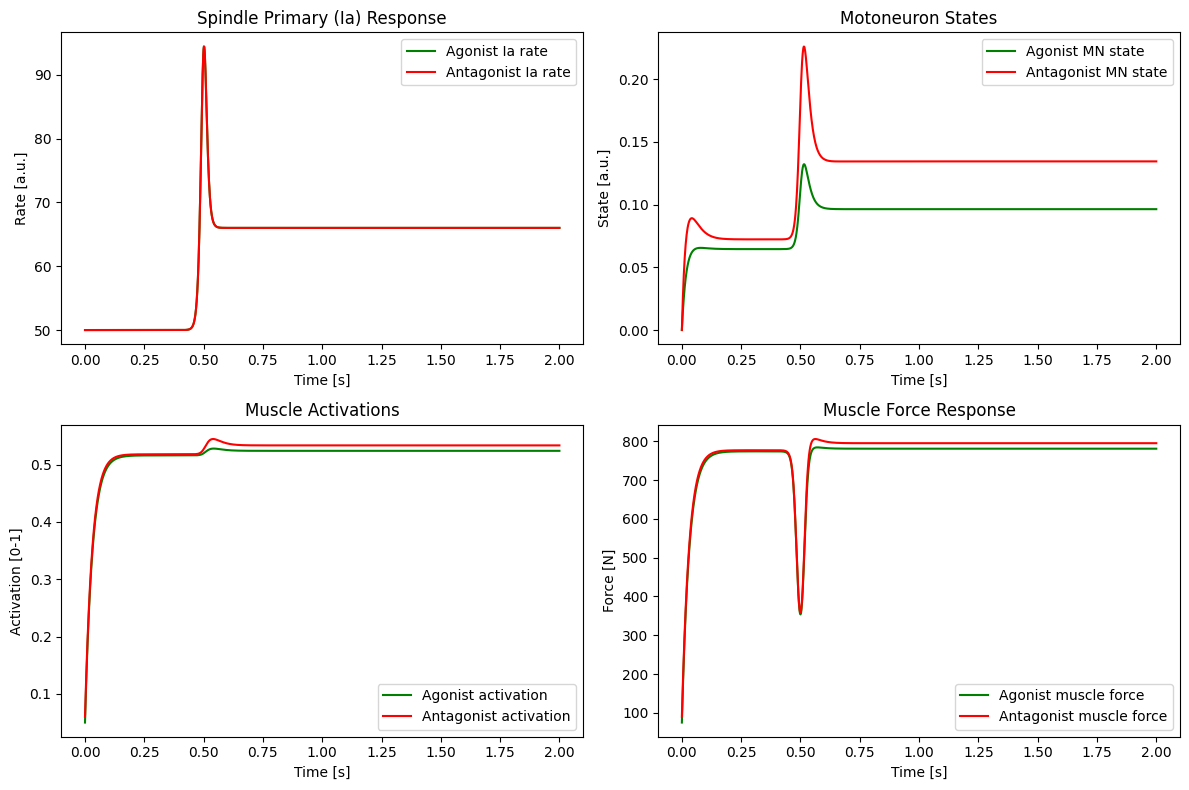

In [75]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot Spindle Ia rate
axs[0, 0].plot(t, Ia, color="green", label="Agonist Ia rate")
axs[0, 0].plot(t, Ia_ant, color="red", label="Antagonist Ia rate")
axs[0, 0].set_xlabel("Time [s]")
axs[0, 0].set_ylabel("Rate [a.u.]")
axs[0, 0].set_title("Spindle Primary (Ia) Response")
axs[0, 0].legend()

# Plot motoneuron states
axs[0, 1].plot(t, a_mn, color="green", label="Agonist MN state")
axs[0, 1].plot(t, a_mn_ant, color="red", label="Antagonist MN state")
axs[0, 1].set_xlabel("Time [s]")
axs[0, 1].set_ylabel("State [a.u.]")
axs[0, 1].set_title("Motoneuron States")
axs[0, 1].legend()

# Plot muscle activations
axs[1, 0].plot(t, A, color="green", label="Agonist activation")
axs[1, 0].plot(t, A_ant, color="red", label="Antagonist activation")
axs[1, 0].set_xlabel("Time [s]")
axs[1, 0].set_ylabel("Activation [0-1]")
axs[1, 0].set_title("Muscle Activations")
axs[1, 0].legend()

# Plot muscle force response
axs[1, 1].plot(t, Fm, color="green", label="Agonist muscle force")
axs[1, 1].plot(t, Fm_ant, color="red", label="Antagonist muscle force")
axs[1, 1].set_xlabel("Time [s]")
axs[1, 1].set_ylabel("Force [N]")
axs[1, 1].set_title("Muscle Force Response")
axs[1, 1].legend()

plt.tight_layout()
plt.savefig(os.path.join(ANTAGONIST_DIR, "antagonist_comparison.png"))
plt.show()
plt.close()

- **Spindle Primary Response:** The spindle primary response ($I_a$) is identical for both the agonist and antagonist, as it depends only on the shared muscle length and velocity.
- **Alpha Motoneuron State:** The motoneuron state ($a_{mn}$) over time is similar in shape for both muscles but lower in the agonist due to the values set in $k_F$, $w_{Ia}$ and $w_{Ib}$.
- **Motoneuron Output and Muscle Activation:** Muscle activation ($A$) follows a similar shape for both muscles but is slightly lower in the agonist, reflecting the reduced motoneuron output.
- **Muscle Force Response:** Muscle force responses ($F_m$) are similar in shape but slightly lower in the agonist, as force is directly proportional to activation.

## IV. Couple to a joint

To couple the stretch reflex model to a joint in MuJoCo, we need to replace the imposed muscle length trajectory with muscle–tendon kinematics derived from joint angles and moment arms. Additionally, muscle forces will be mapped to joint torques via the moment arms.

In [76]:
def muscle_tendon_kinematics(theta, dtheta, L0, r):
    """
    Compute muscle length and velocity from joint angle and velocity.
    Args:
        theta: Joint angle [rad].
        dtheta: Joint angular velocity [rad/s].
        L0: Resting muscle length [norm].
        r: Moment arm [m].
    Returns:
        L: Muscle length [norm].
        dLdt: Muscle velocity [norm/s].
    """
    L = L0 - r * theta  # Muscle length decreases as the joint flexes
    dLdt = -r * dtheta  # Muscle velocity is proportional to joint velocity
    return L, dLdt

In [77]:
# Modify the ODE function
def reflex_ode_joint(t, y, sp, gb, mn, mp, sp_ant, gb_ant, mn_ant, mp_ant, L0, L0_ant, r, r_ant, I):
    """
    ODE for coupled agonist-antagonist muscles acting on a joint.
    Args:
        t: Time [s].
        y: State vector [a_mn, A, a_mn_ant, A_ant, theta, dtheta].
        sp, gb, mn, mp: Parameters for agonist.
        sp_ant, gb_ant, mn_ant, mp_ant: Parameters for antagonist.
        L0, L0_ant: Resting muscle lengths for agonist and antagonist.
        r, r_ant: Moment arms for agonist and antagonist.
        I: Joint moment of inertia [kg·m^2].
    Returns:
        dydt: Time derivatives of the state vector.
    """
    a_mn, A, a_mn_ant, A_ant, theta, dtheta = y

    # Muscle-tendon kinematics
    L, dLdt = muscle_tendon_kinematics(theta, dtheta, L0, r)
    L_ant, dLdt_ant = muscle_tendon_kinematics(theta, dtheta, L0_ant, r_ant)

    # Dynamics
    Ia = spindle_Ia(L, dLdt, sp)
    Fm = muscle_force(A, L, dLdt, mp)
    Ib = golgi_Ib(Fm, gb)

    Ia_ant = spindle_Ia(L_ant, dLdt_ant, sp_ant)
    Fm_ant = muscle_force(A_ant, L_ant, dLdt_ant, mp_ant)
    Ib_ant = golgi_Ib(Fm_ant, gb_ant)

    # Reciprocal inhibition
    I_agonist = mn.w_Ia * Ia - mn.w_Ib * Ib - 0.002 * Ia_ant
    I_antagonist = mn_ant.w_Ia * Ia_ant - mn_ant.w_Ib * Ib_ant - 0.002 * Ia

    # Motoneuron and activation dynamics
    da_mn = (-a_mn + max(0.0, I_agonist)) / mn.tau_mn
    u = sigmoid(a_mn)
    dA = (-A + u) / mp.tau_act

    da_mn_ant = (-a_mn_ant + max(0.0, I_antagonist)) / mn_ant.tau_mn
    u_ant = sigmoid(a_mn_ant)
    dA_ant = (-A_ant + u_ant) / mp_ant.tau_act

    # Joint dynamics
    torque = r * Fm - r_ant * Fm_ant  # Net torque from agonist and antagonist
    d2theta = torque / I  # Angular acceleration (Newton's second law)

    return [da_mn, dA, da_mn_ant, dA_ant, dtheta, d2theta]

In [78]:
# Joint parameters
I = 0.01  # Joint moment of inertia [kg·m^2]
L0 = 1.0 
L0_ant = 1.0 
r = 0.05
r_ant = 0.05 

# Extend the state vector
y0 = [0.0, 0.05, 0.0, 0.05, 0.0, 0.0]  # [a_mn, A, a_mn_ant, A_ant, theta, dtheta]

# Solve the ODE for the coupled muscles acting on a joint
sol = solve_ivp(lambda t, y: reflex_ode_joint(t, y, sp, gb, mn, mp, sp_ant, gb_ant, mn_ant, mp_ant, L0, L0_ant, r, r_ant, I),
                t_span, y0, t_eval=t_eval, rtol=1e-6, atol=1e-8)

# Extract simulation results
theta = sol.y[4]
dtheta = sol.y[5]

print("Simulation complete.")

Simulation complete.


In [79]:
JOINT_DIR = SAVE_DIR + "joint/"
os.makedirs(JOINT_DIR, exist_ok=True)

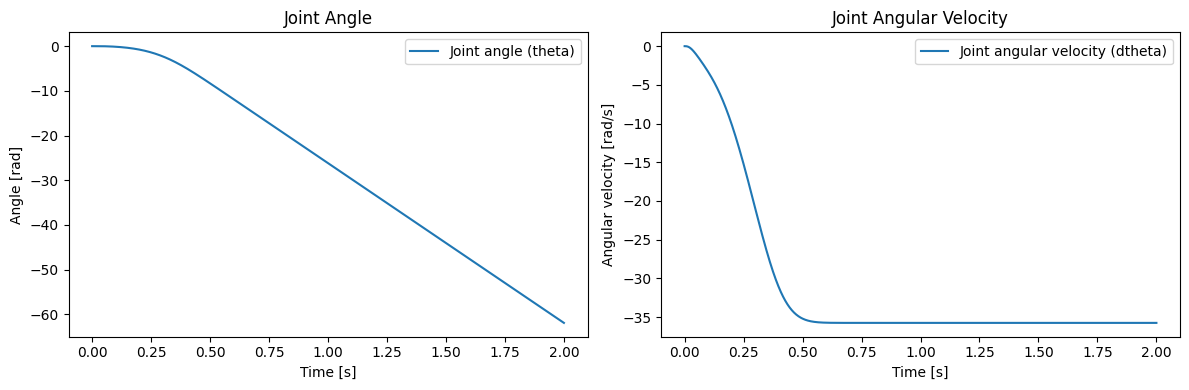

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot joint angle
axs[0].plot(t, theta, label="Joint angle (theta)")
axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel("Angle [rad]")
axs[0].set_title("Joint Angle")
axs[0].legend()

# Plot joint angular velocity
axs[1].plot(t, dtheta, label="Joint angular velocity (dtheta)")
axs[1].set_xlabel("Time [s]")
axs[1].set_ylabel("Angular velocity [rad/s]")
axs[1].set_title("Joint Angular Velocity")
axs[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(JOINT_DIR, "joint_kinematics.png"))
plt.show()
plt.close()

- **Joint Angle ($\theta$):** The joint angle steadily decreases from 0 to approximately -60 rad over the simulation, indicating a continuous rotation driven by the net torque from the muscles.
- **Joint Angular Velocity ($\dot{\theta}$):** The joint angular velocity rapidly drops from 0 to -35 rad/s within the first 0.5 seconds and then stabilizes at this plateau, suggesting that the net torque reaches a steady state after the initial transient phase.

## V. Integrate the reflex model into a hierarchical controller

The current stretch reflex block reproduces spinal reflex dynamics in isolation.  
The next step is to integrate it as the low-level (spinal) layer of a hierarchical control model.

#### 1. Afferent pathway (sensory feedback to controller)

In [81]:
def afferent_feedback(theta, dtheta, Ia, Ib, Fm):
    """Packages proprioceptive feedback signals for the high-level controller."""
    
    return {
        "joint_angle": theta,
        "joint_velocity": dtheta,
        "spindle_Ia": Ia,
        "golgi_Ib": Ib,
        "muscle_force": Fm
    }

#### 2. Efferent pathway (controller commands to reflex model)
The high-level controller will take the proprioceptive feedback and generate commands for the motoneurons.

In [82]:
class HighLevelController:
    def __init__(self, kp=1.0, kd=0.1, ki=0.01, desired_angle=0.0):
        """
        Initialize the high-level controller with control gains and desired angle.

        Args:
            kp (float): Proportional gain.
            kd (float): Derivative gain.
            ki (float): Integral gain.
            desired_angle (float): Target joint angle [rad].
        """
        self.kp = kp
        self.kd = kd
        self.ki = ki
        self.desired_angle = desired_angle

        self.command = 0.0
        self.command_ant = 0.0
        self.integral_error = 0.0

    def process_feedback(self, feedback, dt):
        """
        Process proprioceptive feedback and generate efferent commands.

        Args:
            feedback (dict): Proprioceptive feedback signals containing:
                joint_angle, joint_velocity, spindle_Ia, golgi_Ib, muscle_force
            dt (float): Time step [s].

        Returns:
            tuple: (command, command_ant) for agonist and antagonist motoneurons.
        """
        # Compute error terms
        error = self.desired_angle - feedback["joint_angle"]  # Proportional term
        derror = -feedback["joint_velocity"]  # Derivative term
        self.integral_error += error * dt  # Accumulate the integral of the error

        # Compute commands
        self.command = self.kp * error + self.kd * derror + self.ki * self.integral_error  # Agonist command
        self.command_ant = -self.kp * error - self.kd * derror - self.ki * self.integral_error  # Antagonist command

        return self.command, self.command_ant

#### 3. Modify the Reflex ODE to Include Commands

- Compute the time step (dt) dynamically to update the high-level controller's integral error. 
- Add a damping term to the joint dynamics to stabilize oscillations. 
- Integrate the high-level controller's proportional, derivative, and integral commands into the motoneuron inputs.

In [83]:
def reflex_ode_joint_with_control(t, y, sp, gb, mn, mp, sp_ant, gb_ant, mn_ant, mp_ant, 
                                  L0, L0_ant, r, r_ant, I, controller, last_t=[0]):
    """
    ODE for coupled agonist-antagonist muscles acting on a joint with high-level control.
    Args:
        t: Time [s].
        y: State vector [a_mn, A, a_mn_ant, A_ant, theta, dtheta].
        controller: High-level controller instance.
    Returns:
        dydt: Time derivatives of the state vector.
    """
    a_mn, A, a_mn_ant, A_ant, theta, dtheta = y

    # Muscle-tendon kinematics
    L, dLdt = muscle_tendon_kinematics(theta, dtheta, L0, r)
    L_ant, dLdt_ant = muscle_tendon_kinematics(theta, dtheta, L0_ant, r_ant)

    # Dynamics
    Ia = spindle_Ia(L, dLdt, sp)
    Fm = muscle_force(A, L, dLdt, mp)
    Ib = golgi_Ib(Fm, gb)

    Ia_ant = spindle_Ia(L_ant, dLdt_ant, sp_ant)
    Fm_ant = muscle_force(A_ant, L_ant, dLdt_ant, mp_ant)
    Ib_ant = golgi_Ib(Fm_ant, gb_ant)

    # Compute time step (dt)
    dt = t - last_t[0]
    last_t[0] = t  # Update the last time

    # Get high-level control commands
    feedback = afferent_feedback(theta, dtheta, Ia, Ib, Fm)
    command, command_ant = controller.process_feedback(feedback, dt)

    # Reciprocal inhibition with high-level control
    I_agonist = mn.w_Ia * Ia - mn.w_Ib * Ib - 0.002 * Ia_ant + command
    I_antagonist = mn_ant.w_Ia * Ia_ant - mn_ant.w_Ib * Ib_ant - 0.002 * Ia + command_ant

    # Motoneuron and activation dynamics
    da_mn = (-a_mn + max(0.0, I_agonist)) / mn.tau_mn
    u = sigmoid(a_mn)
    dA = (-A + u) / mp.tau_act

    da_mn_ant = (-a_mn_ant + max(0.0, I_antagonist)) / mn_ant.tau_mn
    u_ant = sigmoid(a_mn_ant)
    dA_ant = (-A_ant + u_ant) / mp_ant.tau_act

    # Joint dynamics
    damping = 0.1  # Damping coefficient
    torque = r * Fm - r_ant * Fm_ant - damping * dtheta
    d2theta = torque / I  # Angular acceleration

    return [da_mn, dA, da_mn_ant, dA_ant, dtheta, d2theta]

#### 4. Integrate the High-Level Controller into the Simulation

In [84]:
# Initialize the high-level controller with custom gains and desired angle
controller = HighLevelController(kp=1.0, kd=0.1, ki=0.01, desired_angle=np.pi/6)

# Solve the ODE with high-level control
sol = solve_ivp(lambda t, y: reflex_ode_joint_with_control(t, y, sp, gb, mn, mp, sp_ant, gb_ant, mn_ant, mp_ant, 
                                                           L0, L0_ant, r, r_ant, I, controller),
                t_span, y0, t_eval=t_eval, rtol=1e-6, atol=1e-8, dense_output=True)

# Extract simulation results
theta = sol.sol(t_eval)[4]
dtheta = sol.sol(t_eval)[5] 

print("Simulation complete.")

Simulation complete.


In [85]:
CONTROL_DIR = SAVE_DIR + "control/"
os.makedirs(CONTROL_DIR, exist_ok=True)

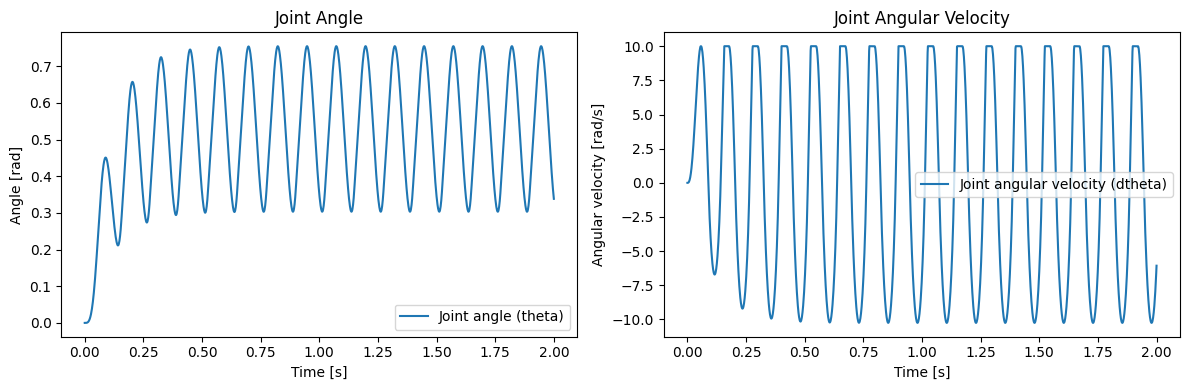

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot joint angle
axs[0].plot(t, theta, label="Joint angle (theta)")
axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel("Angle [rad]")
axs[0].set_title("Joint Angle")
axs[0].legend()

# Plot joint angular velocity
axs[1].plot(t, dtheta, label="Joint angular velocity (dtheta)")
axs[1].set_xlabel("Time [s]")
axs[1].set_ylabel("Angular velocity [rad/s]")
axs[1].set_title("Joint Angular Velocity")
axs[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(CONTROL_DIR, "joint_kinematics.png"))
plt.show()
plt.close()

- **Joint Angle ($\theta$):** The joint angle oscillates between 0.3 rad and 0.75 rad, centered around the desired_angle $ = \frac{\pi}{6}$ (~0.52 rad). These oscillations occur as the system attempts to stabilize the joint at the desired angle while responding to feedback and reflex dynamics.
- **Joint Angular Velocity ($\dot{\theta}$):** The joint angular velocity oscillates between -10.0 rad/s and 10.0 rad/s, centered around 0.00. These oscillations reflect the system's effort to counteract rapid changes in the joint angle.

The oscillations result from the interaction between proportional-derivative control, which drives the joint toward the desired angle while dampening rapid changes, and the reflex dynamics, which balance muscle forces. The damping term helps reduce the amplitude of these oscillations, ensuring stability within realistic ranges.

---

## VI. Integration with Kinesis

- Branching Strategy: Create a new branch in the Kinesis repository to experiment with this reflex model. You can name it something like reflex_model_integration.
- Proprioceptive Inputs: Replace the toy proprioceptive inputs with more realistic ones derived from the MuJoCo simulation environment. For example, use joint angles, velocities, and muscle forces computed by MuJoCo.

#### 4. Training on Easy Trajectories
- Trajectory Generation: Start with simple joint trajectories (e.g., sinusoidal or step inputs) and train the high-level controller to modulate the reflex model to follow these trajectories.
- Loss Function: Use a loss function that penalizes the difference between the desired and actual joint angles/velocities.

#### 5. Next Steps
- Experimentation: Test the reflex model with and without high-level control to evaluate its performance.
- Iterative Refinement: Adjust the reflex parameters and high-level control strategy based on the results.